## Clone code from ggColab_DRL_single_stock_trading_OK.ipynb

In [1]:
!git clone https://github.com/pqmsoft1/FinRL_single.git

Cloning into 'FinRL_single'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 94 (delta 20), reused 80 (delta 9), pack-reused 0
Unpacking objects: 100% (94/94), done.


In [2]:

!pip uninstall -y tensorflow==2.6.0

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0


In [ ]:
'''
!pip install yfinance
!pip install pandas
!pip install matplotlib
!pip install stockstats
!pip install gym
!pip install stable-baselines[mpi]
!pip install tensorflow==1.15.4
'''


In [3]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4

     |████████████████████████████████| 6.3 MB 6.3 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=16a3dd7d343710ea7d99ce1999f5233e6ddce5c6c578087425b86191c1b8134d
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 240 kB 4.4 MB/s 
     |████████████████████████████████| 2.4 MB 20.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.1-cp37-cp37m-linux_x86_64.whl size=2180601 sha256=531f0066f4e117b647e641075f7a6cda0e138bce7c0dc74ce337e407f9540594
  Stored in directory: /root/.cache/pip/wheels/91/be/c0/2b0347be1de5cd8ca9fe67da7ec8c3fe8930fcb6b0df6

In [ ]:
cd FinRL_single/

In [ ]:
!ls

Clone1_ggColab_DRL_single_stock_trading_OK.ipynb
contributing.md
DMaster.docx
docker
DRL_multiple_stock_trading.ipynb
DRL_single_stock_trading.ipynb
figs
finrl
FinRL_demo_docker.ipynb
FinRL_ensemble_stock_trading_ICAIF_2020.ipynb
FinRL_portfolio_allocation_NeurIPS_2020.ipynb
FinRL_single.ipynb
FinRL_single_stock_trading.ipynb
FinRL_stock_trading_fundamental.ipynb
FinRL_stock_trading_NeurIPS_2018.ipynb
ggColab_DRL_single_stock_trading_OK.ipynb
LICENSE
main.py
notebooks
README.md
requirements.txt
setup.py
SingleStock.docx
tests


In [ ]:
cd FinRL_single

/content/FinRL_single


In [ ]:
import yfinance as yf
from stockstats import StockDataFrame as Sdf

import pandas as pd
import matplotlib.pyplot as plt

import gym
from stable_baselines import PPO2, DDPG, A2C, ACKTR, TD3
from stable_baselines import DDPG
from stable_baselines import A2C
from stable_baselines import SAC
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpPolicy
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')


#stockerID = "AMZN"
stockerID = "MSFT"
#stockerID = "TSLA"
stockerID ="FDX"
START_DATE_DATA = "2006-01-01"
END_DATE_DATA = "2021-09-20"

END_DATE_TRAIN_DATA = "2021-07-01"

PATH_CSV_STOCK = stockerID + ".csv"

data_df = yf.download(stockerID, start=START_DATE_DATA, end=END_DATE_DATA)
# reset the index, we want to use numbers instead of dates
data_df=data_df.reset_index()
# convert the column names to standardized names
data_df.columns = ['datadate','open','high','low','close','adjcp','volume']
# save the data to a csv file in your current folder
#data_df.to_csv('AAPL_2009_2020.csv')
#data_df.to_csv('FB_2009_2021.csv')
data_df.to_csv(PATH_CSV_STOCK)
# check missing data 
data_df.isnull().values.any()
# calculate technical indicators like MACD
stock = Sdf.retype(data_df.copy())
# we need to use adjusted close price instead of close price
stock['close'] = stock['adjcp']
data_df['macd'] = stock['macd']
# check missing data again
data_df.isnull().values.any()
# Note that I always use a copy of the original data to try it track step by step.
data_clean = data_df.copy()


import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# Global variables
HMAX_NORMALIZE = 200
INITIAL_ACCOUNT_BALANCE=100000
STOCK_DIM = 1

# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001
# REWARD_SCALING = 1e-3


class SingleStockEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0):
        #super(StockEnv, self).__init__()
        # date increment
        self.day = day
        self.df = df
        # action_space normalization and the shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 4: [Current Balance]+[prices]+[owned shares] +[macd] 
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (4,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        # termination
        self.terminal = False  
        # save the total number of trades
        self.trades = 0
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM + \
                      [self.data.macd] 
        # initialize reward and cost
        self.reward = 0
        self.cost = 0
        
        # memorize the total value, total rewards
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []

    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.state[index+STOCK_DIM+1] > 0:
            # update balance
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             (1- TRANSACTION_FEE_PERCENT)
            # update held shares
            self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
            # update transaction costs
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            pass
            
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        available_amount = self.state[0] // self.state[index+1]
        #update balance
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ TRANSACTION_FEE_PERCENT)
        # update held shares
        self.state[index+STOCK_DIM+1] += min(available_amount, action)
        # update transaction costs
        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          TRANSACTION_FEE_PERCENT
        self.trades+=1
        
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('account_value.png')
            plt.close()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0])) 
            print("end_total_asset:{}".format(end_total_asset))
            
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('account_value.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))- INITIAL_ACCOUNT_BALANCE ))
            print("total_cost: ", self.cost)
            print("total trades: ", self.trades)
            
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            
            if df_total_value['daily_return'].std()!=0:
                sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                      df_total_value['daily_return'].std()
                print("Sharpe: ",sharpe)
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('account_rewards.csv')
            return self.state, self.reward, self.terminal,{}

        else:
            
            # actions are the shares we need to buy, hold, or sell
            actions = actions * HMAX_NORMALIZE
            # calculate begining total asset
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            
            # perform buy or sell action
            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])
            
            # update data, walk a step s'
            self.day += 1
            self.data = self.df.loc[self.day,:]         
            #load next state
            self.state =  [self.state[0]] + \
                          [self.data.adjcp] + \
                          list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) +\
                          [self.data.macd]
                        
            # calculate the end total asset
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.reward = end_total_asset - begin_total_asset  
            self.rewards_memory.append(self.reward)
            #self.reward = self.reward * REWARD_SCALING
            self.asset_memory.append(end_total_asset)

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM + \
                      [self.data.macd]
        return self.state
    
    def render(self, mode='human'):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


train = data_clean[(data_clean.datadate>=START_DATE_DATA) & (data_clean.datadate < END_DATE_TRAIN_DATA)]
# the index needs to start from 0
train=train.reset_index(drop=True)

## Model Training: 4 models, PPO A2C, DDPG, TD3
## Model 1: PPO

#tensorboard --logdir ./single_stock_tensorboard/
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ppo = PPO2('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_ppo.learn(total_timesteps=100000,tb_log_name="run_aapl_ppo")
#model_ppo.save('AAPL_ppo_100k')
#model_ppo.save('AAPL_ppo_100k')
#model_sticker_save = 'FB_ppo_100k'
model_sticker_save = 'amzn_ppo_100k'
model_ppo.save(model_sticker_save)



env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ppo = PPO2('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
#model_ppo.load('AAPL_ppo_100k.zip')
model_ppo.load(model_sticker_save)



# Trading
# Assume that we have $100,000 initial capital at 2019-01-01. We use the TD3 model to trade AAPL.
## sau khi chay xong: create file account_rewards.csv, account_value.csv, account_value.png 


test = data_clean[(data_clean.datadate >= END_DATE_TRAIN_DATA) ]
# the index needs to start from 0
test=test.reset_index(drop=True)


#model = model_a2c
model = model_ppo
#model = model_td3
#model = model_ddpg
env_test = DummyVecEnv([lambda: SingleStockEnv(test)])
obs_test = env_test.reset()
print("==============Model Prediction===========")
for i in range(len(test.index.unique())):
    action, _states = model.predict(obs_test)
    obs_test, rewards, dones, info = env_test.step(action)
    env_test.render()

#==> Create file account_rewards.csv, account_value.csv, account_value.png sau khi chay xong


'''
Part 5: Backtest Our Strategy
For simplicity purposes, in the article, we just calculate the Sharpe ratio and the annual return manually.
'''


def get_DRL_sharpe():
    df_total_value=pd.read_csv('account_value.csv',index_col=0)
    df_total_value.columns = ['account_value']
    df_total_value['daily_return']=df_total_value.pct_change(1)
    sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
    df_total_value['daily_return'].std()
    
    annual_return = ((df_total_value['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)
    return df_total_value


def get_buy_and_hold_sharpe(test):
    test['daily_return']=test['adjcp'].pct_change(1)
    sharpe = (252**0.5)*test['daily_return'].mean()/ \
    test['daily_return'].std()
    annual_return = ((test['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)

    print("sharpe ratio: ", sharpe)
    #return sharpe

df_total_value=get_DRL_sharpe()
get_buy_and_hold_sharpe(test)
DRL_cumulative_return = (df_total_value.account_value.pct_change(1)+1).cumprod()-1
buy_and_hold_cumulative_return = (test.adjcp.pct_change(1)+1).cumprod()-1



%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(test.datadate, DRL_cumulative_return, color='red',label = "DRL")
plt.plot(test.datadate, buy_and_hold_cumulative_return, label = "Buy & Hold")
plt.title("Cumulative Return for AAPL with Transaction Cost",size= 20)
plt.legend()
plt.rc('legend',fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)


## Model Training: 4 models, PPO A2C, DDPG, TD3
## Model 1: PPO

In [ ]:
#tensorboard --logdir ./single_stock_tensorboard/
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ppo = PPO2('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_ppo.learn(total_timesteps=100000,tb_log_name="run_aapl_ppo")
#model_ppo.save('AAPL_ppo_100k')
#model_ppo.save('AAPL_ppo_100k')
#model_sticker_save = 'FB_ppo_100k'
model_sticker_save = 'amzn_ppo_100k'
model_ppo.save(model_sticker_save)

## Model 2: DDPG

In [ ]:
#tensorboard --logdir ./single_stock_tensorboard/
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ddpg = DDPG('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
#model_ddpg.learn(total_timesteps=100000, tb_log_name="run_aapl_ddpg")
#model_ddpg.save('AAPL_ddpg_50k')

In [ ]:
model_ddpg.learn(total_timesteps=100000, tb_log_name="run_aapl_ddpg")
model_ddpg.save('AAPL_ddpg_50k')

#model_ddpg.save(model_sticker_save)


## Model 3: A2C

In [ ]:
#tensorboard --logdir ./single_stock_tensorboard/
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_a2c = A2C('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_a2c.learn(total_timesteps=100000,tb_log_name="run_aapl_a2c")
#model_a2c.save('AAPL_a2c_50k')

In [ ]:
model_a2c.save('AAPL_a2c_50k')
#model_a2c.save(model_sticker_save)

## Model 4: TD3

In [ ]:
#tensorboard --logdir ./single_stock_tensorboard/
#DQN<DDPG<TD3
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_td3 = TD3('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
#model_td3.learn(total_timesteps=100000,tb_log_name="run_aapl_td3")
#model_td3.save('AAPL_td3_50k')
model_td3.learn(total_timesteps=100000,tb_log_name="run_aapl_td3")
model_td3.save('AAPL_td3_50k')
#model_td3.save(model_sticker_save)


## Testing data

## Load model from file save

## Load model PPO

In [ ]:
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ppo = PPO2('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
#model_ppo.load('AAPL_ppo_100k.zip')
model_ppo.load(model_sticker_save)


## Load models a2c

In [ ]:
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_a2c = A2C('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_a2c.load(model_sticker_save)

## Load model ddpg

In [ ]:
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ddpg = DDPG('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
#model_ddpg.load('AAPL_ddpg_50k.zip')
model_ddpg.load(model_sticker_save)



## Load model td3

In [ ]:
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_td3 = TD3('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_td3.load('AAPL_td3_50k.zip')


# Trading
Assume that we have $100,000 initial capital at 2019-01-01. We use the TD3 model to trade AAPL.

## sau khi chay xong: create file account_rewards.csv, account_value.csv, account_value.png 

In [ ]:

test = data_clean[(data_clean.datadate >= END_DATE_TRAIN_DATA) ]
# the index needs to start from 0
test=test.reset_index(drop=True)




In [ ]:
test

,datadate,open,high,low,close,adjcp,volume,macd
0,2021-07-01,299.950012,300.100006,296.820007,299.119995,298.276398,1749500,-0.766531
1,2021-07-02,299.899994,299.899994,297.369995,299.380005,298.535645,1335800,-0.491762
2,2021-07-06,299.380005,299.630005,292.600006,294.609985,293.779083,2282500,-0.650325
3,2021-07-07,294.000000,295.149994,291.239990,293.549988,292.722076,2293200,-0.851463
4,2021-07-08,287.160004,294.619995,285.850006,293.239990,292.412964,1971400,-1.024005
5,2021-07-09,295.809998,298.200012,293.179993,296.399994,295.564056,2317500,-0.896149
6,2021-07-12,297.279999,302.239990,294.600006,299.670013,298.824860,1905400,-0.525644
7,2021-07-13,298.989990,302.649994,298.690002,299.079987,298.236481,1747700,-0.276307
8,2021-07-14,298.649994,300.859985,294.600006,295.859985,295.025574,1431800,-0.333950
9,2021-07-15,294.000000,298.739990,293.670013,296.079987,295.244934,1166000,-0.357808


In [ ]:
#model = model_a2c
model = model_ppo
#model = model_td3
#model = model_ddpg
env_test = DummyVecEnv([lambda: SingleStockEnv(test)])
obs_test = env_test.reset()
print("==============Model Prediction===========")
for i in range(len(test.index.unique())):
    action, _states = model.predict(obs_test)
    obs_test, rewards, dones, info = env_test.step(action)
    env_test.render()

#==> Create file account_rewards.csv, account_value.csv, account_value.png sau khi chay xong

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:91214.80049134279
total_reward:-8785.199508657213
total_cost:  1216.9028415728942
total trades:  52
Sharpe:  -3.1096071839715838


## Part 5: Backtest Our Strategy
For simplicity purposes, in the article, we just calculate the Sharpe ratio and the annual return manually.

In [ ]:

def get_DRL_sharpe():
    df_total_value=pd.read_csv('account_value.csv',index_col=0)
    df_total_value.columns = ['account_value']
    df_total_value['daily_return']=df_total_value.pct_change(1)
    sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
    df_total_value['daily_return'].std()
    
    annual_return = ((df_total_value['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)
    return df_total_value


def get_buy_and_hold_sharpe(test):
    test['daily_return']=test['adjcp'].pct_change(1)
    sharpe = (252**0.5)*test['daily_return'].mean()/ \
    test['daily_return'].std()
    annual_return = ((test['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)

    print("sharpe ratio: ", sharpe)
    #return sharpe

df_total_value=get_DRL_sharpe()
get_buy_and_hold_sharpe(test)
DRL_cumulative_return = (df_total_value.account_value.pct_change(1)+1).cumprod()-1
buy_and_hold_cumulative_return = (test.adjcp.pct_change(1)+1).cumprod()-1


annual return:  -34.2962179054769
sharpe ratio:  -3.1096071839715633
annual return:  -50.82201630086771
sharpe ratio:  -3.7496910745541077


In [ ]:
#DRL_cumulative_return

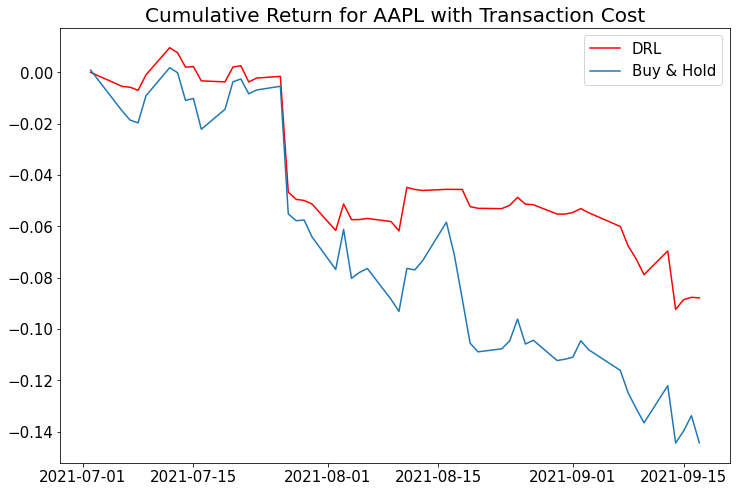

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(test.datadate, DRL_cumulative_return, color='red',label = "DRL")
plt.plot(test.datadate, buy_and_hold_cumulative_return, label = "Buy & Hold")
plt.title("Cumulative Return for AAPL with Transaction Cost",size= 20)
plt.legend()
plt.rc('legend',fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

In [ ]:
from google.colab import files

files.download('AAPL_a2c_50k.zip')
files.download('AAPL_td3_50k.zip')
files.download('AAPL_ppo_100k.zip')
files.download('AAPL_ddpg_50k.zip')